# Audio Classification
Gizem Tabak

We will first build a speech/music classifier that identifies if an audio segment contains speech or music. Then, we will build a music genre classifier that can identify 5 different genres.

In [ ]:
#@title Import modules, define helper functions
%matplotlib inline
import scipy.signal as sgn
import scipy.io.wavfile as wv
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import IPython
from scipy.stats import multivariate_normal
from matplotlib import mlab as mlab
from os.path import join
import librosa
import time
import os
from sklearn import mixture

plt.rcParams["figure.figsize"] = (12, 6)

def stft( input_sound, fs, dft_size, hop_size, zero_pad, window):
    if len(np.shape(input_sound)) == 1:
        # Forward transform
        input_sound_padded = np.zeros(len(input_sound) + dft_size - zero_pad + hop_size - len(input_sound)%hop_size)
        input_sound_padded[:len(input_sound)] = input_sound
        L = len(input_sound_padded) -  dft_size
        stft_output = np.zeros([int((dft_size)/2) + 1, int(L/hop_size)], dtype=complex)
        for i in range(0, int(L/hop_size)):
            seg = input_sound_padded[(i*hop_size):(i*hop_size + dft_size - zero_pad)]
            # Choose and apply window if selected
            if window == 'triangular':
                seg = np.multiply(seg, np.bartlett(dft_size - zero_pad))
            elif window == 'hann':
                seg = np.multiply(seg, np.hanning(dft_size - zero_pad))
            elif window == 'hamming':
                seg = np.multiply(seg, np.hamming(dft_size - zero_pad))
            elif window == 'kaiser':
                seg = np.multiply(seg, np.kaiser(dft_size - zero_pad, beta=0.8))
            # Change size variable so that it will pad zeros to input    
            s_stft = np.fft.rfft(seg, dft_size)            
            stft_output[:,i] = s_stft
            
        t_axis = np.arange(0, (int(L/hop_size)*hop_size)/fs, hop_size/fs)
        f_axis = np.arange(0, fs/2, fs/(2*(int((dft_size)/2) + 1)))
        # # Make zero elements equal to the smallest value to avoid log(0) for plotting
        # min_nonzero = np.min(stft_output[np.nonzero(stft_output)])
        # stft_output[stft_output == 0] = min_nonzero
# 
        '''
        plt.pcolormesh(t_axis, f_axis, (np.abs(stft_output)**0.4), cmap='gist_gray_r')
        plt.xlabel('Time (sec)')
        plt.ylabel('Freq (Hz)')
        plt.title('DFT=%d HOP=%d PAD=%d WINDOW=%s' %(dft_size, hop_size, zero_pad, window))
        plt.grid(alpha=0.5)
        plt.colorbar()
        plt.show()
        '''

        return stft_output, t_axis, f_axis
    elif len(np.shape(input_sound)) == 2:
        # Inverse transform
        L = (np.shape(input_sound)[1]+1)*hop_size
        stft_output = np.zeros([int(L)+hop_size,])
        for i in range(0, int((L - dft_size)/hop_size)):
            s_stft = np.fft.irfft(input_sound[:,i], dft_size)
            if len(window) > 0:
                # Window should only cover nonzero part, not zero paddings
                if window == 'triangular':
                    w = np.bartlett(dft_size - zero_pad)
                elif window == 'hann':
                    w = np.hanning(dft_size - zero_pad)
                elif window == 'hamming':
                    w = np.hamming(dft_size - zero_pad)
                elif window == 'kaiser':
                    w = np.kaiser(dft_size - zero_pad, beta=0.8)
                # Pad window with zeros to make dimensions equal
                window_padded = np.concatenate([w, np.zeros([zero_pad,])])
                s_stft = np.multiply(s_stft, window_padded)
            # Overlap and add
            stft_output[i*hop_size:(i*hop_size + dft_size)] += s_stft
        
        return stft_output

## Part 1: Making a speech detector
_We will design a simple classifier that will let us know if its input is speech or non- speech using [data/SpeechMusic folder in this dataset](https://drive.google.com/file/d/1oAnvk-hzzgzZ4di4W0p-Kw6v3IWLm9u2X/view?usp=sharing)._

I'll start by randomly selecting 50 sound files for each class.

In [ ]:
def get_train_test_ids():
    # Get training file id's
    all_idx = np.arange(1,61)
    speech_train_id = rnd.choice(all_idx, size=50, replace=False)
    music_train_id  = rnd.choice(all_idx, size=50, replace=False)

    # Get test file id's
    speech_id_mask = np.ones(np.shape(all_idx), dtype=bool)
    speech_id_mask[speech_train_id-1] = False
    speech_test_id = all_idx[speech_id_mask]

    music_id_mask = np.ones(np.shape(all_idx), dtype=bool)
    music_id_mask[music_train_id-1] = False
    music_test_id = all_idx[music_id_mask]
    return speech_train_id, music_train_id, speech_test_id, music_test_id

First I built the training and test datasets by selecting random file id's from each directory.

In [ ]:
def build_speech_train(speech_train_id):
    # Delete before building the training set if the data matrix already exists 
    if 'speech_train' in locals():
        del speech_train
    for s_file_idx in speech_train_id:
        fs, s = wv.read('data/SpeechMusic/speech/%d.wav'%(s_file_idx))
        s_stft, t, f = stft(s, fs, dft_size, hop_size, zero_pad, window)
        s_stft_log = np.abs(s_stft)**0.3
        if 'speech_train' in locals():
            speech_train = np.append(speech_train, s_stft_log, axis=1)
        else:
            speech_train = s_stft_log
    return speech_train

In [ ]:
def build_music_train(music_train_id):
    # Delete before building the training set if the data matrix already exists 
    if 'music_train' in locals():
        del music_train
    for m_file_idx in music_train_id:
        fs, s = wv.read('data/SpeechMusic/music/%d.wav'%(m_file_idx))
        s_stft, t, f = stft(s, fs, dft_size, hop_size, zero_pad, window)
        s_stft_log = np.abs(s_stft)**0.3
        if 'music_train' in locals():
            music_train = np.append(music_train, s_stft_log, axis=1)
        else:
            music_train = s_stft_log
    return music_train

For each class, I computed mean vectors ($\mu_s, \mu_m$) and covariance matrices ($\Sigma_s$, $\Sigma_m$) from the training sets to estimate the parameters of the Gaussian models that represent each class.

In [ ]:
def estimate_model_params(speech_train, music_train):
    speech_mean = np.mean(speech_train, axis=1)
    speech_cov  = np.diag(np.var(speech_train, axis=1))

    music_mean = np.mean(music_train, axis=1)
    music_cov  = np.diag(np.var(music_train, axis=1))
    return speech_mean, speech_cov , music_mean , music_cov  

In our dataset, each time frame vector that contains frequency information for that time frame is one data sample. This correcponds to the columns of the datasets. In order to calculate likelihoods of the data points given the model parameters estimated from the training sets, I used the following likelihood functions:

$\mathcal{L}(d \in m|D_m^{(tr)}) = \log P(d|\mu_m, \Sigma_m)$

$\mathcal{L}(d \in \: s\:|D_s^{(tr)}) = \log P(d|\mu_s, \Sigma_s)$


where $\mathcal{L}(d \in c|D_c^{(tr)})$ represents the log-likelihood of a data point $d$ being of class $c (\in \{m,s\})$ given the training data for that class, and $P(.|\mu, \Sigma)$ is the Gaussian probability density function with mean $\mu$ and covariance $\Sigma$.

In our dataset, the covariance matrix is diagonal. So, calculating its inverse, determinant and the Gaussian pdf is trivial. On the other hand, built-in SciPy multivatiate Gaussian pdf function is designed to handle much more complex multivariate data. Probably because of this intricacy, it works slow. So I used a small function that calculates log likelihoods given diagonal covariance matrix.

In [ ]:
def calculate_log_pdf(x, m, C):
    C_diag = np.diagonal(C)    
    # Check if C is diagonal
    if np.all(C == np.diag(C_diag)):
        # (Log) Normalizing constant
        log_norm_const = -0.5*(len(C_diag)*np.log(2.*np.pi) + np.sum(np.log(C_diag)))
        log_exp = - 0.5*np.dot((x - m).T, (1./C_diag)*(x - m))
        return log_norm_const + log_exp
    else:
        print('This function is practical for independent samples. Using multivariate_normal.pdf for nondiagonal cov matrix.')
        return multivariate_normal.pdf(music_test[:,i], music_mean,  music_cov)

In [ ]:
%timeit multivariate_normal.pdf(speech_train[:,0], speech_mean, speech_cov)

12.5 ms ± 424 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit calculate_log_pdf(speech_train[:,0], speech_mean,  speech_cov)

164 µs ± 7.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


To calculate the overall likelihood of a video clip belonging one class, I sum the log-likelihoods of each sample (time frame) in that given clip.

In [ ]:
def calculate_speech_log_likelihood(speech_test_id, speech_mean, speech_cov , music_mean , music_cov):
    # Speech is class 0, music is class 1
    # Likelihood of speech test clips
    L_speech = np.zeros([2, len(speech_test_id)])

    for i in np.arange(len(speech_test_id)):
        s_file_idx = speech_test_id[i]
        fs, s = wv.read('data/SpeechMusic/speech/%d.wav'%(s_file_idx))
        s_stft, t, f = stft(s, fs, dft_size, hop_size, zero_pad, window)
        s_stft_log = np.abs(s_stft)**0.3
        for j in np.arange(np.size(s_stft_log, axis=1)):
            L_speech[0,i] += calculate_log_pdf(s_stft_log[:,j], speech_mean,  speech_cov)
            L_speech[1,i] += calculate_log_pdf(s_stft_log[:,j], music_mean,  music_cov)
    return L_speech

In [ ]:
def calculate_music_log_likelihood(music_test_id, speech_mean, speech_cov , music_mean , music_cov):
    # Speech is class 0, music is class 1
    # Likelihood of music test clips
    L_music  = np.zeros([2, len(music_test_id)])
    for i in np.arange(len(music_test_id)):
        m_file_idx = music_test_id[i]
        fs, s = wv.read('data/SpeechMusic/music/%d.wav'%(m_file_idx))
        s_stft, t, f = stft(s, fs, dft_size, hop_size, zero_pad, window)
        s_stft_log = np.abs(s_stft)**0.3
        for j in np.arange(np.size(s_stft_log, axis=1)):
            L_music[0,i] += calculate_log_pdf(s_stft_log[:,j], speech_mean,  speech_cov)
            L_music[1,i] += calculate_log_pdf(s_stft_log[:,j], music_mean,  music_cov)
    return L_music

$L_{speech}$ is a $2 \times M_s$ matrix where $M_s$ is the number of test clips that belong to speech class. If our trained model were able to classify these two classes with 100% accuracy, we would expect each element of the first row to be greater than the corresponding element in the second row (i.e. $L_{speech}[0,i] > L_{speech}[1,i]$ for all $i \in \{0,\dots,M_s-1\}$). Similarly, $L_{music}[1,i] > L_{music}[0,i]$ for all $i \in \{0,\dots,M_m-1\}$.

Based on this notation, I calculated confusion matrix that would give accuracy of our prediction for each class, and also false predictions.

In [ ]:
def confusion_matrix(L_speech, L_music):
    CM = np.zeros([2,2])
    # Num of correct speech test classification 
    correct_speech = np.sum(L_speech[0,:] > L_speech[1,:])
    # Num of correct music test classification 
    correct_music = np.sum(L_music[1,:] > L_music[0,:])
    CM[0,0] = correct_speech/len(L_speech[0,:])
    CM[0,1] = 1.0 - correct_speech/len(L_speech[0,:])
    CM[1,0] = 1.0 - correct_music/len(L_speech[0,:])
    CM[1,1] = correct_music/len(L_speech[0,:])
    return CM

In order to try different random partitions of data and compare results, I implemented the classification procedure 10 times.

In [ ]:
dft_size = 512
zero_pad = dft_size//2
hop_size = dft_size//4
window   = 'hann'
# Number of total trials
num_trial = 10
CM_total = np.zeros([2,2,num_trial])
for nt in np.arange(num_trial):
    start = time.time()
    speech_train_id, music_train_id, speech_test_id, music_test_id = \
        get_train_test_ids()
    speech_train = build_speech_train(speech_train_id)
    music_train  = build_music_train(music_train_id)
    speech_mean, speech_cov , music_mean , music_cov = estimate_model_params(speech_train, music_train)
    L_speech = calculate_speech_log_likelihood(speech_test_id, speech_mean, speech_cov , music_mean , music_cov)
    L_music = calculate_music_log_likelihood(music_test_id, speech_mean, speech_cov , music_mean , music_cov)
    CM_total[:,:,nt] = confusion_matrix(L_speech, L_music)
    stop = time.time()
    duration = stop-start
    print('Experiment %d is complete. Speech accuracy=%.1f, Music accuracy=%.1f. Took %.2f secs'%(nt+1, CM_total[0,0,nt], CM_total[1,1,nt], duration))

Experiment 1 is complete. Speech accuracy=1.0, Music accuracy=0.4. Took 69.83 secs
Experiment 2 is complete. Speech accuracy=0.9, Music accuracy=0.8. Took 64.22 secs
Experiment 3 is complete. Speech accuracy=1.0, Music accuracy=0.8. Took 68.02 secs
Experiment 4 is complete. Speech accuracy=0.9, Music accuracy=0.7. Took 64.20 secs
Experiment 5 is complete. Speech accuracy=1.0, Music accuracy=0.6. Took 61.08 secs
Experiment 6 is complete. Speech accuracy=0.9, Music accuracy=0.8. Took 65.11 secs
Experiment 7 is complete. Speech accuracy=1.0, Music accuracy=0.7. Took 70.45 secs
Experiment 8 is complete. Speech accuracy=0.9, Music accuracy=0.6. Took 64.91 secs
Experiment 9 is complete. Speech accuracy=1.0, Music accuracy=0.9. Took 62.56 secs
Experiment 10 is complete. Speech accuracy=0.9, Music accuracy=0.7. Took 64.85 secs


I also tried different DFT sizes. I obtained the best overall accuracy with DFT size 256. Based on the results, the classifier can classify speech more accurately than music.

In [ ]:
# DFT_size 2048
np.mean(CM4_total, axis=2)

array([[0.85, 0.15],
       [0.24, 0.76]])

In [ ]:
# DFT_size 512
np.mean(CM_total, axis=2)

array([[0.95, 0.05],
       [0.3 , 0.7 ]])

In [ ]:
# DFT_size 256
np.mean(CM2_total, axis=2)

array([[0.92, 0.08],
       [0.23, 0.77]])

In [ ]:
# DFT_size 128
np.mean(CM3_total, axis=2)

array([[0.92, 0.08],
       [0.25, 0.75]])

## Part 2: Making a music genre classifier

Now, we will build a genre classifier for music clips. This time, we will use MFCC features instead of STFT's. MFCC's are short-term, spectral-based features just like STFT features. But they are constructed by nonlinear mappings of amplitude and frequency scales. They are preferred features in speech and audio because they mimic how auditory system works more closely than STFTs.

Also, instead of using a simple bivariate Gaussian model, this time we will use a Gaussian Mixture Model (GMM) for classification. GMM assumes each data sample we see in a class is generated from a mixture (sum) of finite number of Gaussian distributions. When we fit a GMM to a class, we learn the parameters (mean and covariance) of each Gaussian using expectation-maximization algorithm.

First, I divided each genre's files into train and test sets so that each set has equal number of music clips. Then, I calculated MFCC's and appended them to appropriate training and test data matrices while keeping song time frame indices for classificaiton.

In [ ]:
directory = 'data/genres/'
genre_array = os.listdir(directory)
train_data    = dict.fromkeys(genre_array) # np.empty((len(genre_array),0,0))
test_data     = dict.fromkeys(genre_array) # np.empty((len(genre_array),0,0))

train_file_id = dict.fromkeys(genre_array) # np.empty((len(genre_array), 50), int)
test_file_id  = dict.fromkeys(genre_array) # np.empty((len(genre_array), 50), int)
n_train_frames= dict.fromkeys(genre_array)
n_test_frames = dict.fromkeys(genre_array)

for genre in genre_array:
    files = librosa.util.find_files(directory+genre)
    all_idx = np.arange(0,len(files))
    train_file_id[genre] = rnd.choice(all_idx, size=len(files)//2, replace=False)
    
    id_mask = np.ones(np.shape(all_idx), dtype=bool)
    id_mask[train_file_id[genre]] = False
    test_file_id[genre] = all_idx[id_mask]
    
    first_train_flag = True
    first_test_flag  = True
    # Number of train/test frames in each file
    nf_train = np.array([0])
    nf_test  = np.array([0])
    # Build training and test set
    for j in np.arange(len(files)):
        filename = files[j]
        # Load files
        s, fs    = librosa.load(filename, sr = None)
        if j in train_file_id[genre]:
            # Add mfcc's to training set
            if first_train_flag:
                trd_genre = librosa.feature.mfcc(y=s, sr=fs, n_mfcc=128)
                first_train_flag = False
            else:
                trd_genre = np.append(trd_genre, librosa.feature.mfcc(y=s, sr=fs, n_mfcc=128), axis=1)
            nf_train = np.append(nf_train, np.size(trd_genre,1))
        else:
            # Add mfcc's to training set
            if first_test_flag:
                ted_genre = librosa.feature.mfcc(y=s, sr=fs, n_mfcc=128)
                first_test_flag = False
            else:
                ted_genre = np.append(ted_genre, librosa.feature.mfcc(y=s, sr=fs, n_mfcc=128), axis=1)
            nf_test = np.append(nf_test, np.size(ted_genre,1))
            
    train_data[genre] = trd_genre
    test_data[genre]  = ted_genre
    n_train_frames[genre] = nf_train
    n_test_frames[genre]  = nf_test

Then, I fit a Gaussian model to each genre. For this purpose, I used `GaussianMixture` function with 1 component and a diagonal covariance matrix. In order to test the performance of each classifiers, I calculated the sum of log-likelihoods of test examples given the classifier. In order to calculate sum-log-likelihoods, I used `score` function. To predict the class of a test clip, I chose the `max` of sum-log-likelihoods over all genres.

In order to calculate prediction accuracies and confusions with other classes, I compared the predicted genres with the true ones.

In [ ]:
def train_multivariate_gaussian(n_components):
    gmm_mult       = dict.fromkeys(genre_array)
    predicted_class_mult = dict.fromkeys(genre_array)
    for genre in genre_array:
        gmm_mult[genre] = mixture.GaussianMixture(n_components, covariance_type='diag')
        gmm_mult[genre].fit(train_data[genre].T)
    for genre in genre_array:
        predicted_class_mult[genre] = []
        for i in np.arange(len(n_train_frames[genre])-1):
            train_clip = train_data[genre][:,(n_train_frames[genre][i]):(n_train_frames[genre][i+1])]
            predicted_class_mult[genre].append(genre_array[np.argmax([gmm_mult[g].score(train_clip.T)*np.size(train_clip,1) for g in genre_array])])
            CM_train = np.zeros((len(genre_array), len(genre_array)))
    for i in range(len(genre_array)):
        g_true = genre_array[i]
        d_mult = dict(zip(*np.unique(predicted_class_mult[g_true], return_counts=True)))
        for g in d_mult.keys():
            CM_train[i, genre_array.index(g)] = d_mult[g]
    return gmm_mult, CM_train

In [ ]:
def test_multivariate_gaussian(gmm_mult):
    predicted_class_mult = dict.fromkeys(genre_array)
    for genre in genre_array:
        predicted_class_mult[genre] = []
        for i in np.arange(len(n_test_frames[genre])-1):
            test_clip = test_data[genre][:,(n_test_frames[genre][i]):(n_test_frames[genre][i+1])]
            predicted_class_mult[genre].append(genre_array[np.argmax([gmm_mult[g].score(test_clip.T)*np.size(test_clip,1) for g in genre_array])])
            CM_test = np.zeros((len(genre_array), len(genre_array)))
    for i in range(len(genre_array)):
        g_true = genre_array[i]
        d_mult = dict(zip(*np.unique(predicted_class_mult[g_true], return_counts=True)))
        for g in d_mult.keys():
            CM_test[i, genre_array.index(g)] = d_mult[g]
    return CM_test

In [ ]:
def plot_confusion_matrix(cm, classes, title, normalize):
    # Code modified from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest',cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' # if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()   
               

For a model with single Gaussian component, training accuracy seem to be lower than test accuracy for all of the classes. This indicates a possible underfitting meaning the model is not representative enough of the data.

Based on both training and test confusion matrix, it seems like classical, metal and pop songs can be classified with relatively high accuracy using single Gaussian model for each class. However, disco and reggae get confused with pop frequently. One interesting thing to note is, this confusion is not bidirectional. Meaning, pop was not confused with disco or reggae as much as disco and reggae was confused with pop.

Num of components = 1, Overall train accuracy = 0.76
Num of components = 1, Overall test accuracy = 0.86


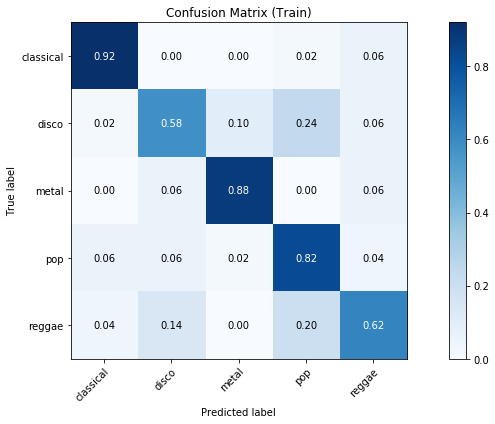

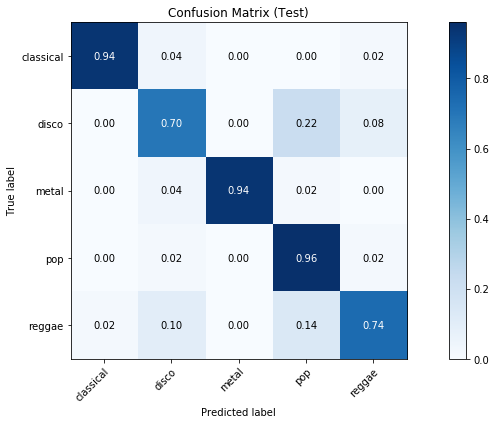

In [ ]:
n_components = 1
gmm, CM_train = train_multivariate_gaussian(n_components)
CM_test = test_multivariate_gaussian(gmm)
plot_confusion_matrix(CM_train, genre_array, 'Confusion Matrix (Train)', normalize=True)
plot_confusion_matrix(CM_test, genre_array, 'Confusion Matrix (Test)', normalize=True)
print('Num of components = %d, Overall train accuracy = %.2f'%(n_components, np.mean(np.diag(CM_train))/50.))
print('Num of components = %d, Overall test accuracy = %.2f'%(n_components, np.mean(np.diag(CM_test))/50.))

I wanted to examine the discrepancy of accuracies between classes with a few small tests. By looking at the distance between the centers of each cluster pair, $||\mu_{c_i} - \mu_{c_j}||^2$, we can see that classical and metal music are the furthest two, which makes sense considering their distinct musical structure. Interestingly, disco and metal are the genre pairs that have the closest cluster centers; but they do not get confused as much as others. This might be because metal has a densely packed cluster compared to others. We can test this by examining the cluster variances.

Assuming MFCC bins are independent, we can get an idea of how packed a genre cluster is by looking at the sum of the covariance values of that genre. The lower this value is, the packed the cluster would be. Although this assumption is probably inaccurate, it can provide some insight. As expected, metal has the lowest value. Even though it is closer to other clusters, it does not get confused as much because it is densely packed. On the other hand, disco and pop are both close to each other and both are relatively more loosely packed. Hence, they get confused more. 

This little examination does not reveal why pop does not get confused with disco as much while disco gets confused with pop. By assuming independence and summing the variance of each dimension, we lose some information about the direction of their spread in `n_mfcc`-D space. Pop might have higher variance in directions (more) orthogonal to disco, and/or disco might have more test samples "closer" to pop cluster on its higher-spreading dimensions.

Genre     | ~Var
classical | 24360.929673
disco     | 12074.669371
metal     | 7791.651458
pop       | 15410.862920
reggae    | 17543.120836


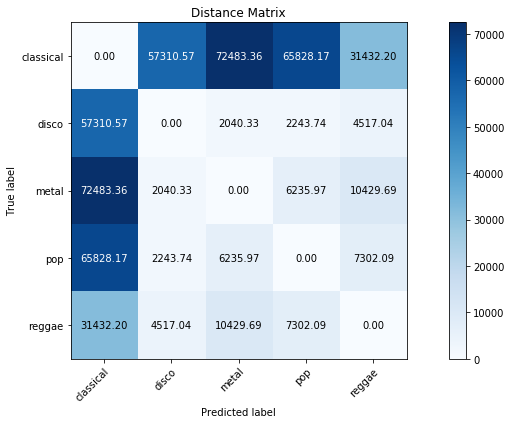

In [ ]:
D = np.zeros((len(genre_array), len(genre_array)))
V = np.zeros(len(genre_array))
i = 0
for g1 in genre_array:
    j = 0
    for g2 in genre_array:
        D[i, j] = np.sum((gmm[g1].means_ - gmm[g2].means_)**2)
        j += 1
    V[i] = np.sum(gmm[g1].covariances_[0])
    i += 1
plot_confusion_matrix(D, genre_array, 'Distance Matrix', normalize=False)
print('Genre     | ~Var')
p=[print('{:9s} | {:5f}'.format(genre_array[i], V[i])) for i in range(5)]

Increasing the number of Gaussian components in the mixture to 2 increased overall training accuracy. However, it is still less than test accuracy, and the test accuracy stayed the same. This means we can increase complexity of the model more to make it more explanatory.

Num of components = 2, Overall train accuracy = 0.81
Num of components = 2, Overall test accuracy = 0.86


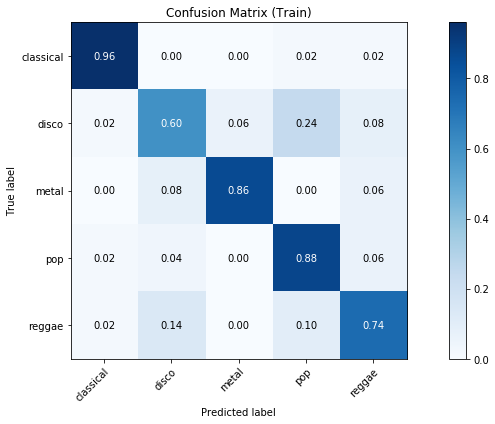

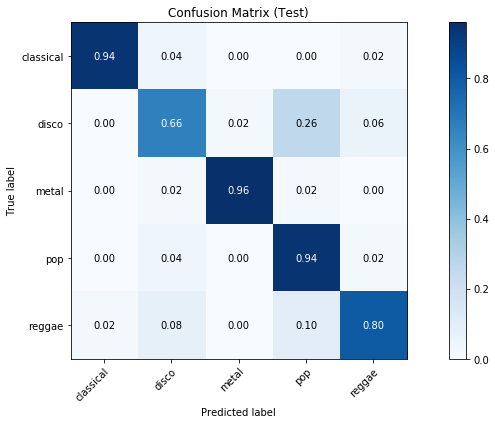

In [ ]:
n_components = 2
gmm, CM_train = train_multivariate_gaussian(n_components)
CM_test = test_multivariate_gaussian(gmm)
plot_confusion_matrix(CM_train, genre_array, 'Confusion Matrix (Train)', normalize=True)
plot_confusion_matrix(CM_test, genre_array, 'Confusion Matrix (Test)', normalize=True)
print('Num of components = %d, Overall train accuracy = %.2f'%(n_components, np.mean(np.diag(CM_train))/50.))
print('Num of components = %d, Overall test accuracy = %.2f'%(n_components, np.mean(np.diag(CM_test))/50.))

With 3 components, both training and test accuracy increased. With 3 components, the model is able to explain the data much better.

Num of components = 3, Overall train accuracy = 0.84
Num of components = 3, Overall test accuracy = 0.88


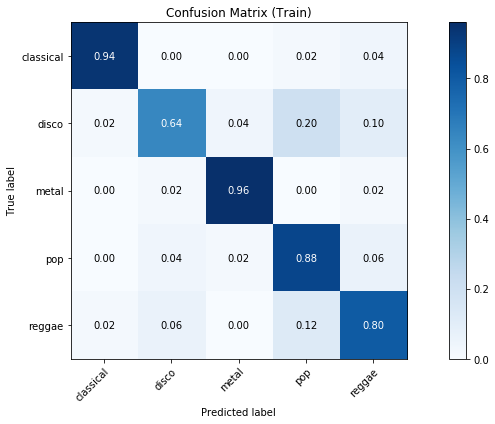

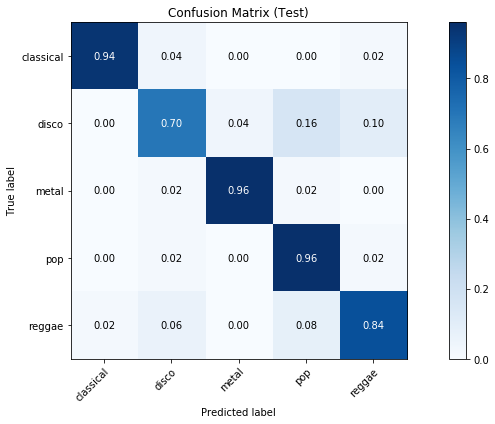

In [ ]:
n_components = 3
gmm, CM_train = train_multivariate_gaussian(n_components)
CM_test = test_multivariate_gaussian(gmm)
plot_confusion_matrix(CM_train, genre_array, 'Confusion Matrix (Train)', normalize=True)
plot_confusion_matrix(CM_test, genre_array, 'Confusion Matrix (Test)', normalize=True)
print('Num of components = %d, Overall train accuracy = %.2f'%(n_components, np.mean(np.diag(CM_train))/50.))
print('Num of components = %d, Overall test accuracy = %.2f'%(n_components, np.mean(np.diag(CM_test))/50.))

With 4 components, it seems the oveall training accuracy has increased, but the test accuracy decreased both compared to the case with 3 component and compared to the training accuracy. This indicates a slight overfitting and increasing the number of components further will probably introduce more overfitting and decrease the test accuracy.

Num of components = 4, Overall train accuracy = 0.88
Num of components = 4, Overall test accuracy = 0.86


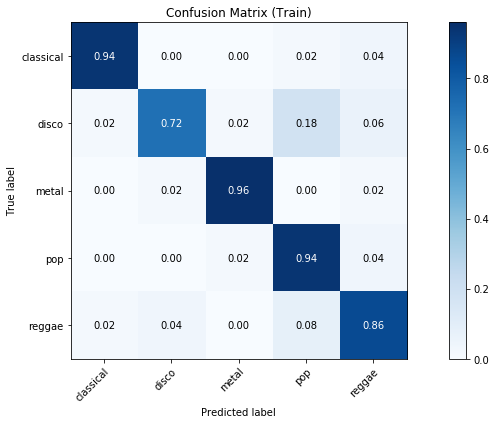

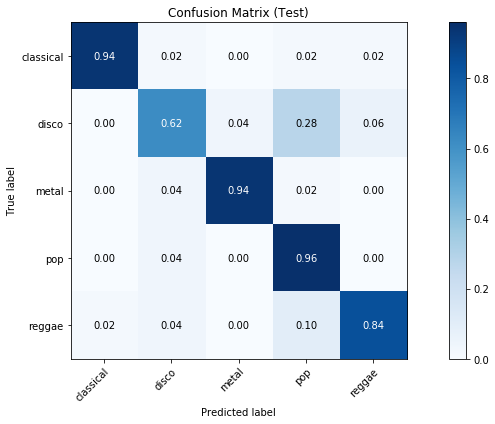

In [ ]:
n_components = 4
gmm, CM_train = train_multivariate_gaussian(n_components)
CM_test = test_multivariate_gaussian(gmm)
plot_confusion_matrix(CM_train, genre_array, 'Confusion Matrix (Train)', normalize=True)
plot_confusion_matrix(CM_test, genre_array, 'Confusion Matrix (Test)', normalize=True)
print('Num of components = %d, Overall train accuracy = %.2f'%(n_components, np.mean(np.diag(CM_train))/50.))
print('Num of components = %d, Overall test accuracy = %.2f'%(n_components, np.mean(np.diag(CM_test))/50.))

As expected, increasing the number of components made the model more complicated and made it overfit the data. As a result, test accuracy decreased even further.

Num of components = 5, Overall train accuracy = 0.88
Num of components = 5, Overall test accuracy = 0.83


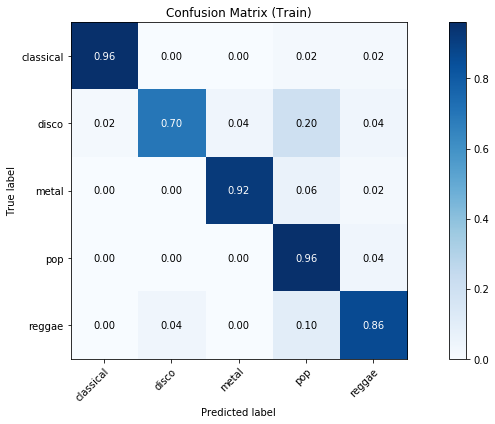

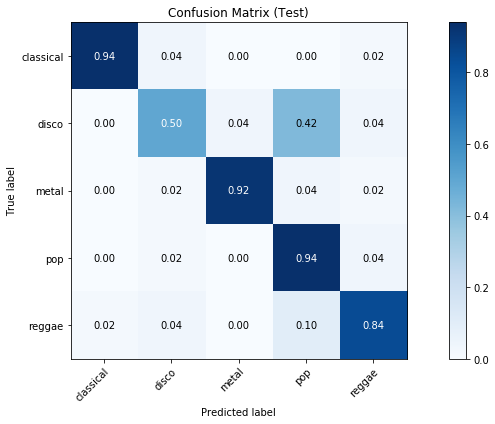

In [ ]:
n_components = 5
gmm, CM_train = train_multivariate_gaussian(n_components)
CM_test = test_multivariate_gaussian(gmm)
plot_confusion_matrix(CM_train, genre_array, 'Confusion Matrix (Train)', normalize=True)
plot_confusion_matrix(CM_test, genre_array, 'Confusion Matrix (Test)', normalize=True)
print('Num of components = %d, Overall train accuracy = %.2f'%(n_components, np.mean(np.diag(CM_train))/50.))
print('Num of components = %d, Overall test accuracy = %.2f'%(n_components, np.mean(np.diag(CM_test))/50.))

And increasing the number of components to 20 increased overfitting much more, resulting in 94% training accuracy while keeping the test accuracy at 86%.

Num of components = 20, Overall train accuracy = 0.94
Num of components = 20, Overall test accuracy = 0.86


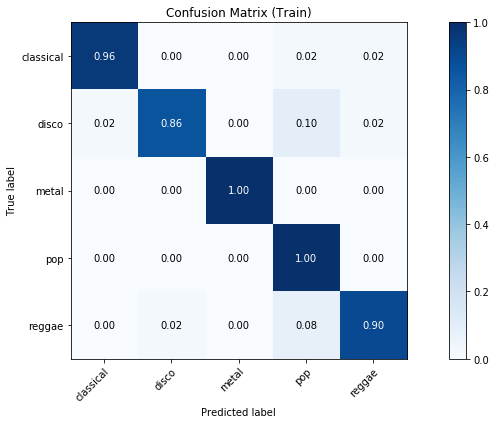

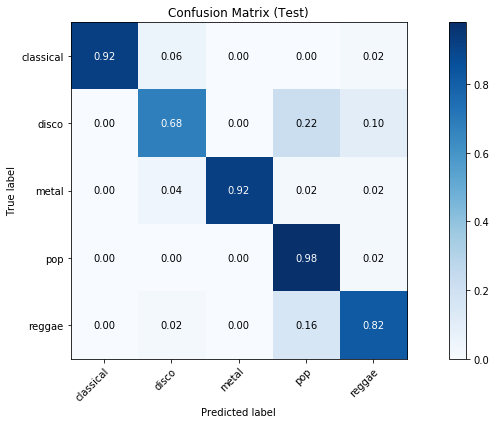

In [ ]:
n_components = 20
gmm, CM_train = train_multivariate_gaussian(n_components)
CM_test = test_multivariate_gaussian(gmm)
plot_confusion_matrix(CM_train, genre_array, 'Confusion Matrix (Train)', normalize=True)
plot_confusion_matrix(CM_test, genre_array, 'Confusion Matrix (Test)', normalize=True)
print('Num of components = %d, Overall train accuracy = %.2f'%(n_components, np.mean(np.diag(CM_train))/50.))
print('Num of components = %d, Overall test accuracy = %.2f'%(n_components, np.mean(np.diag(CM_test))/50.))

Looking at the results for different numbers of components, we can see that the best model for the overall test accuracy is obtained with 3 Gaussian components.

## Part 3: Make it better

With the hopes of making the models better, I tried using PCA on the 128 MFCC's first to identify the most explanatory components of the variance of the data. With the generalization and dimension reduction provided by PCA, we might be able to increase the number of components more without overfitting, and achieve better results.

First I tried keeping 20 components out of 128 with PCA. The results improved a little bit (89% test accuracy), with more number of components (8) as expected.

Then, I tried keeping 50 components out of 128. It improved test accuracy a little bit more (to 91%), with 7 components.

In [ ]:
from sklearn.decomposition import PCA
pca_nw = PCA(n_components=20, copy=True, whiten=False)
all_train_data = train_data[genre_array[0]]
all_train_labels = [genre_array[0]]*np.size(train_data[genre_array[0]], 1)
all_test_data = train_data[genre_array[0]]
all_test_labels = [genre_array[0]]*np.size(train_data[genre_array[0]], 1)
for i in range(1,5):
    all_train_data = np.append(all_train_data, train_data[genre_array[i]], axis=1)
    all_train_labels = np.append(all_train_labels, [genre_array[i]]*np.size(train_data[genre_array[i]], 1))
    all_test_data = np.append(  all_test_data, test_data[genre_array[i]], axis=1)
    all_test_labels = np.append(all_test_labels, [genre_array[i]]*np.size(test_data[genre_array[i]], 1))


In [ ]:
all_train_data_pca = pca_nw.fit_transform(all_train_data.T).T
all_test_data_pca = pca_nw.transform(all_test_data.T).T
np.shape(all_train_data_pca)
np.shape(all_test_data_pca)

(20, 323325)

In [ ]:
train_data_pca = dict.fromkeys(genre_array)
test_data_pca = dict.fromkeys(genre_array)
for genre in genre_array:
    train_data_pca[genre] = all_train_data_pca[:, all_train_labels == genre]
    test_data_pca[genre]  =  all_test_data_pca[:, all_test_labels == genre ]

In [ ]:
def train_multivariate_gaussian_modified(train_data, n_components):
    gmm_mult       = dict.fromkeys(genre_array)
    predicted_class_mult = dict.fromkeys(genre_array)
    for genre in genre_array:
        gmm_mult[genre] = mixture.GaussianMixture(n_components, covariance_type='diag')
        gmm_mult[genre].fit(train_data[genre].T)
    for genre in genre_array:
        predicted_class_mult[genre] = []
        for i in np.arange(len(n_train_frames[genre])-1):
            train_clip = train_data[genre][:,(n_train_frames[genre][i]):(n_train_frames[genre][i+1])]
            predicted_class_mult[genre].append(genre_array[np.argmax([gmm_mult[g].score(train_clip.T)*np.size(train_clip,1) for g in genre_array])])
            CM_train = np.zeros((len(genre_array), len(genre_array)))
    for i in range(len(genre_array)):
        g_true = genre_array[i]
        d_mult = dict(zip(*np.unique(predicted_class_mult[g_true], return_counts=True)))
        for g in d_mult.keys():
            CM_train[i, genre_array.index(g)] = d_mult[g]
    return gmm_mult, CM_train

In [ ]:
def test_multivariate_gaussian_modified(gmm_mult, test_data):
    predicted_class_mult = dict.fromkeys(genre_array)
    for genre in genre_array:
        predicted_class_mult[genre] = []
        for i in np.arange(len(n_test_frames[genre])-1):
            test_clip = test_data[genre][:,(n_test_frames[genre][i]):(n_test_frames[genre][i+1])]
            predicted_class_mult[genre].append(genre_array[np.argmax([gmm_mult[g].score(test_clip.T)*np.size(test_clip,1) for g in genre_array])])
            CM_test = np.zeros((len(genre_array), len(genre_array)))
    for i in range(len(genre_array)):
        g_true = genre_array[i]
        d_mult = dict(zip(*np.unique(predicted_class_mult[g_true], return_counts=True)))
        for g in d_mult.keys():
            CM_test[i, genre_array.index(g)] = d_mult[g]
    return CM_test

In [ ]:
for n_components in range(1,10):
    gmm_pca, CM_train_pca = train_multivariate_gaussian_modified(train_data_pca, n_components)
    CM_test_pca = test_multivariate_gaussian_modified(gmm_pca, test_data_pca)
    # plot_confusion_matrix(CM_train_pca, genre_array, 'Confusion Matrix (Train)', normalize=True)
    # plot_confusion_matrix( CM_test_pca, genre_array, 'Confusion Matrix (Test)', normalize=True)
    print('# of components = %d, Overall train accuracy = %.2f'%(n_components, np.mean(np.diag(CM_train_pca))/50.))
    print('# of components = %d, Overall test accuracy = %.2f'%(n_components, np.mean( np.diag( CM_test_pca))/50.))

# of components = 1, Overall train accuracy = 0.80
# of components = 1, Overall test accuracy = 0.84
# of components = 2, Overall train accuracy = 0.84
# of components = 2, Overall test accuracy = 0.85
# of components = 3, Overall train accuracy = 0.85
# of components = 3, Overall test accuracy = 0.87
# of components = 4, Overall train accuracy = 0.87
# of components = 4, Overall test accuracy = 0.88
# of components = 5, Overall train accuracy = 0.87
# of components = 5, Overall test accuracy = 0.87
# of components = 6, Overall train accuracy = 0.88
# of components = 6, Overall test accuracy = 0.88
# of components = 7, Overall train accuracy = 0.90
# of components = 7, Overall test accuracy = 0.88
# of components = 8, Overall train accuracy = 0.90
# of components = 8, Overall test accuracy = 0.89
# of components = 9, Overall train accuracy = 0.89
# of components = 9, Overall test accuracy = 0.87


In [ ]:
pca_nw = PCA(n_components=50, copy=True, whiten=False)
all_train_data = train_data[genre_array[0]]
all_train_labels = [genre_array[0]]*np.size(train_data[genre_array[0]], 1)
all_test_data = train_data[genre_array[0]]
all_test_labels = [genre_array[0]]*np.size(train_data[genre_array[0]], 1)
for i in range(1,5):
    all_train_data = np.append(all_train_data, train_data[genre_array[i]], axis=1)
    all_train_labels = np.append(all_train_labels, [genre_array[i]]*np.size(train_data[genre_array[i]], 1))
    all_test_data = np.append(  all_test_data, test_data[genre_array[i]], axis=1)
    all_test_labels = np.append(all_test_labels, [genre_array[i]]*np.size(test_data[genre_array[i]], 1))

all_train_data_pca = pca_nw.fit_transform(all_train_data.T).T
all_test_data_pca = pca_nw.transform(all_test_data.T).T

train_data_pca = dict.fromkeys(genre_array)
test_data_pca = dict.fromkeys(genre_array)
for genre in genre_array:
    train_data_pca[genre] = all_train_data_pca[:, all_train_labels == genre]
    test_data_pca[genre]  =  all_test_data_pca[:, all_test_labels == genre ]

In [ ]:
for n_components in range(1,10):
    gmm_pca, CM_train_pca = train_multivariate_gaussian_modified(train_data_pca, n_components)
    CM_test_pca = test_multivariate_gaussian_modified(gmm_pca, test_data_pca)
    # plot_confusion_matrix(CM_train_pca, genre_array, 'Confusion Matrix (Train)', normalize=True)
    # plot_confusion_matrix( CM_test_pca, genre_array, 'Confusion Matrix (Test)', normalize=True)
    print('# of components = %d, Overall train accuracy = %.2f'%(n_components, np.mean(np.diag(CM_train_pca))/50.))
    print('# of components = %d, Overall test accuracy = %.2f'%(n_components, np.mean( np.diag( CM_test_pca))/50.))

# of components = 1, Overall train accuracy = 0.82
# of components = 1, Overall test accuracy = 0.88
# of components = 2, Overall train accuracy = 0.83
# of components = 2, Overall test accuracy = 0.87
# of components = 3, Overall train accuracy = 0.86
# of components = 3, Overall test accuracy = 0.87
# of components = 4, Overall train accuracy = 0.86
# of components = 4, Overall test accuracy = 0.86
# of components = 5, Overall train accuracy = 0.90
# of components = 5, Overall test accuracy = 0.86
# of components = 6, Overall train accuracy = 0.92
# of components = 6, Overall test accuracy = 0.90
# of components = 7, Overall train accuracy = 0.94
# of components = 7, Overall test accuracy = 0.91
# of components = 8, Overall train accuracy = 0.94
# of components = 8, Overall test accuracy = 0.91
# of components = 9, Overall train accuracy = 0.94
# of components = 9, Overall test accuracy = 0.91


Overall train accuracy = 0.94
Overall test accuracy = 0.91


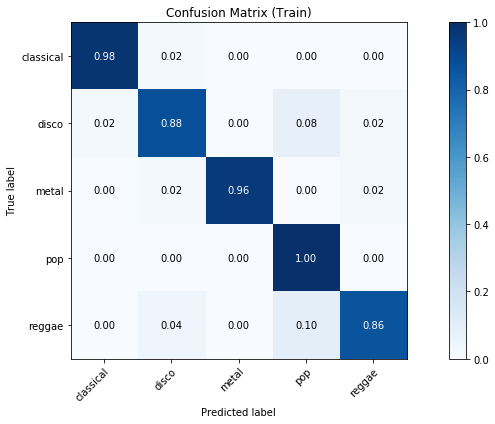

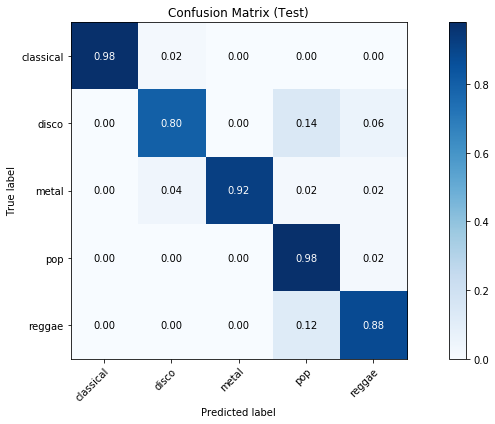

In [ ]:
n_components = 7
gmm_pca, CM_train_pca = train_multivariate_gaussian_modified(train_data_pca, n_components)
CM_test_pca = test_multivariate_gaussian_modified(gmm_pca, test_data_pca)
plot_confusion_matrix(CM_train_pca, genre_array, 'Confusion Matrix (Train)', normalize=True)
plot_confusion_matrix( CM_test_pca, genre_array, 'Confusion Matrix (Test)', normalize=True)
print('Overall train accuracy = %.2f'%(np.mean(np.diag(CM_train_pca))/50.))
print('Overall test accuracy = %.2f'%(np.mean( np.diag( CM_test_pca))/50.))